# Inferlo and libDAI comaprison

In this Notebook we compare several algorithms in InferLO and libDAI in terms of accuracy and performance.

This notebook is also useful as example of how to use libDAI interop.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import inferlo
from inferlo.pairwise.testing import tree_potts_model, grid_potts_model, cross_potts_model, assert_results_close
from inferlo.interop import LibDaiInterop
import time

In [2]:
class Charts:
    def __init__(self):
        self.data = dict()
        
    def add_point(self, alg_name, gr_size, time=None, error=None, acc=None):
        data = {}
        if time is not None:
            data['Time, s']=time
        if error is not None:
            data['Error']=error    
        if acc is not None:
            data['Accuracy']=acc        
        for metric, value in data.items():
            self.data.setdefault(metric, dict()).setdefault(alg_name, []).append((gr_size, value))
            

    def plot(self):
        cnt = len(self.data)
        fig, axs = plt.subplots(1, cnt, figsize=(8*cnt,5))
        if (cnt==1):
            axs = [axs]
        i = 0
        for metric, charts in self.data.items():
            for alg_name in charts:
                x, y = zip(*charts[alg_name])
                axs[i].plot(x, y, label=alg_name)
            axs[i].set_xlabel('Model size')
            axs[i].set_ylabel(metric)
            axs[i].legend(loc=2)
            i += 1
        plt.show()
        
libdai = LibDaiInterop()

## 1. Marginal probabilities on trees

We solve a problem of finding marginal probabilities for random pairwise model on a tree with variables taking 5 possible values. We use 2 exact algorithms: 'tree_dp' (dynamic programming on a tree) from InferLO and 'BP' 
([belief propagation](https://staff.fnwi.uva.nl/j.m.mooij/libDAI/doc/classdai_1_1BP.html)) from libDAI. We check that they give the same results and measure running time.

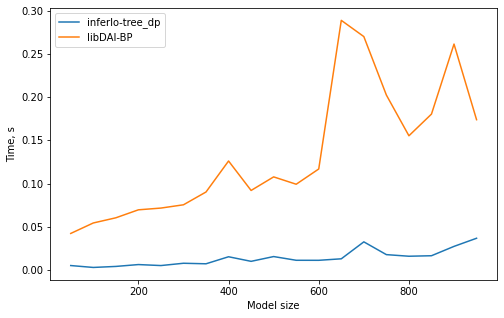

In [3]:
charts = Charts()

for gr_size in np.array(range(1, 20)) * 50:
    model = tree_potts_model(gr_size=gr_size, al_size=5)
    t0 = time.time()
    true_result = model.infer(algorithm='tree_dp')
    charts.add_point("inferlo-tree_dp", gr_size, time=time.time() - t0)
    
    result = libdai.infer(model, algorithm='BP')
    assert_results_close (true_result, result, log_pf_tol=1e-5)
    charts.add_point("libDAI-BP", gr_size, libdai.true_running_time)
    
charts.plot()

## 2. Maximal likelihood on trees

We solve a problem of finding most probable state for random pairwise model on a tree with variables taking 5 possible values. We use 2 exact algorithms: 'tree_dp' (dynamic programming on a tree) from InferLO and 'BP' 
([belief propagation](https://staff.fnwi.uva.nl/j.m.mooij/libDAI/doc/classdai_1_1BP.html)) from libDAI. We check that they give the same results and measure running time.

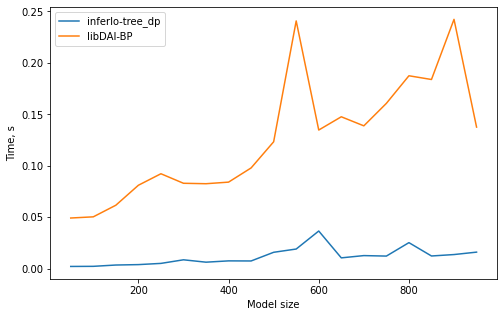

In [4]:
charts = Charts()

for gr_size in np.array(range(1, 20)) * 50:
    model = tree_potts_model(gr_size=gr_size, al_size=5)
    t0 = time.time()
    true_result = model.max_likelihood(algorithm='tree_dp')
    charts.add_point("inferlo-tree_dp", gr_size, time=time.time() - t0)
    
    result = libdai.max_likelihood(model, algorithm='BP')
    assert np.allclose(true_result, result)
    charts.add_point("libDAI-BP", gr_size, libdai.true_running_time)
    
charts.plot()

## 3. Marginal probabilities with junction tree

We generate binary graphical model on a "cross" graph, which is graph of bounded treewidth, and find marginal probabilities for it using junction tree algorithms from InferLO and libDAI ([JTREE](https://staff.fnwi.uva.nl/j.m.mooij/libDAI/doc/classdai_1_1JTree.html)).

We check that results are identical and plot running time.

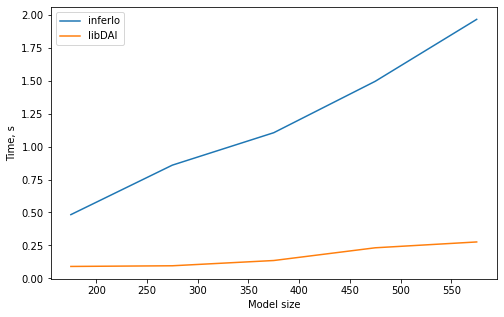

In [5]:
charts = Charts()
for length in np.array(range(2, 7)) * 10:
    model = cross_potts_model(length, width=5, al_size=2, seed=0)
    gr_size = model.gr_size
    
    t0 = time.time()
    result1 = model.infer(algorithm='junction_tree')
    charts.add_point("inferlo", gr_size, time=time.time()-t0)
    
    result2 = libdai.infer(model, algorithm='JTREE')
    charts.add_point("libDAI", gr_size, time=libdai.true_running_time)
    
    inferlo.pairwise.testing.assert_results_close(result1, result2, log_pf_tol=1e-7)
    
charts.plot()

## 4. Marginal probabilities for the grid graph

We consider binary pairwise model on a grid of size 5xN.

We use different (exact and approximate) InferLO and libDAI algorithms to calculate marginal probabilities. We measure running time and error. Error is maximal difference betwen true and calculated marginal probability over all variables.

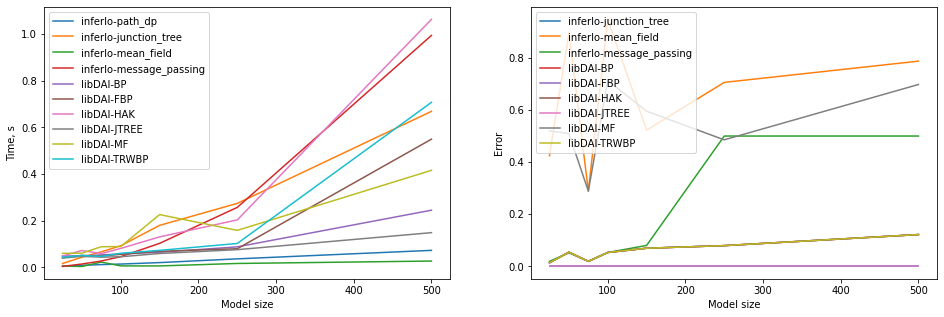

In [6]:
charts = Charts()
for width in [5, 10, 15, 20, 30, 50, 100]:
    model = grid_potts_model(5, width, al_size=2, seed=0)
    gr_size = model.gr_size

    t0 = time.time()
    true_result = model.infer(algorithm='path_dp').marg_prob
    charts.add_point("inferlo-path_dp", gr_size, time=time.time() - t0)
    
    for algo in ['junction_tree', 'mean_field', 'message_passing']:
        t0 = time.time()
        result = model.infer(algorithm=algo).marg_prob
        charts.add_point("inferlo-" + algo, gr_size, time=time.time() - t0, error=np.max(np.abs(result-true_result)))
        
    for algo in ['BP', 'FBP', 'HAK', 'JTREE', 'MF', 'TRWBP']:
        result = libdai.infer(model, algorithm=algo).marg_prob
        charts.add_point("libDAI-" + algo, gr_size, time=libdai.true_running_time, error=np.max(np.abs(result-true_result)))
    
charts.plot()

## 5. Maximal likelihood for the grid graph

We solve a problem of finding most probable state for random pairwise model on a 5xN grid. We measure running time and accuracy. Accuracy is the number of correctly guessed variables.

5
25
50
100
250
375
500


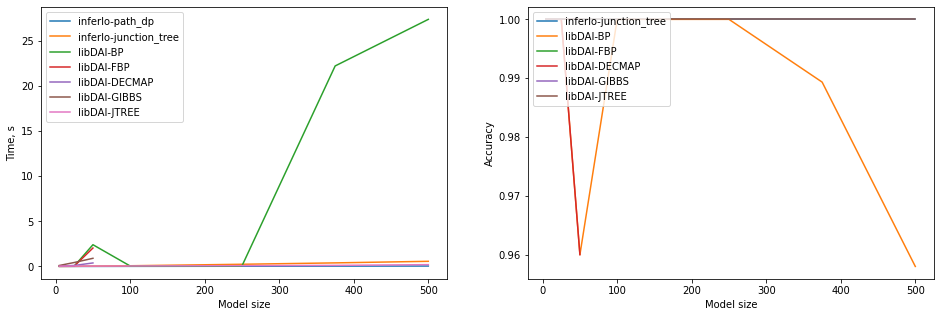

In [7]:
def acc(x, y):
    return sum(x==y) / len(x)

charts = Charts()
for width in [1, 5, 10, 20, 50, 75, 100]:
    model = grid_potts_model(5, width, al_size=2, seed=0)
    gr_size = model.gr_size

    t0 = time.time()
    true_ml = model.max_likelihood(algorithm='path_dp')
    charts.add_point("inferlo-path_dp", gr_size, time=time.time() - t0)
    
    for algo in ['junction_tree']:
        t0 = time.time()
        ml = model.max_likelihood(algorithm=algo)
        charts.add_point("inferlo-" + algo, gr_size, time=time.time() - t0, acc=acc(true_ml, ml))
        
    for algo in ['BP', 'FBP', 'DECMAP', 'GIBBS', 'JTREE']:
        if gr_size > 50 and algo in ['GIBBS', 'DECMAP', 'FBP']:
            continue
               
        ml = libdai.max_likelihood(model, algorithm=algo)
        charts.add_point("libDAI-" + algo, gr_size, time=libdai.true_running_time, acc=acc(true_ml, ml))
    
charts.plot()